In [162]:
# Pronóstico de Series de Tiempo
# Feb 15, 2021
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline


In [163]:
url = 'https://raw.githubusercontent.com/FerminDelgadoR/FisicaComputacional1/master/Evaluacion/Datos_Hawai.txt'

my_cols = ['site_code', 'year', 'month','day', 'hour', ' minute','second', ' time_decimal', 'value', ' value_std_dev', 'nvalue ','  latitude','longitude', 'altitude ', 'elevation', ' intake_height', ' qcflag']
df_dist = pd.read_csv(url, names=my_cols, encoding="cp1251", sep="\s+", header=None, skiprows=152, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = -999.99
df_work1 = df_work0.replace(to_replace=str_Nulo, value='NaN', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['value']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()


df = pd.DataFrame({'day':df_work2['day'],
                   'month':df_work2['month'],
                   'year':df_work2['year']})
df_work2['Fecha']=pd.to_datetime(df).copy()



df_meteo_ts = df_work2.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Verificamos
df_meteo_ts.info()
#print(df_meteo_ts.head())
#print(df_meteo_ts.tail())

# Seleccionaremos un conjunto de años de 30 años, creando las colecciones de datos 
df_90= df_meteo_ts[(df_meteo_ts['year'] >= 1980) & (df_meteo_ts['year'] < 2019)]

df_90=df_90['value']

df_90.ffill(axis = 0, inplace=True)

df_90

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17166 entries, 1973-01-01 to 2019-12-31
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   site_code       17166 non-null  object 
 1   year            17166 non-null  int64  
 2   month           17166 non-null  int64  
 3   day             17166 non-null  int64  
 4   hour            17166 non-null  int64  
 5    minute         17166 non-null  int64  
 6   second          17166 non-null  int64  
 7    time_decimal   17166 non-null  float64
 8   value           13936 non-null  float64
 9    value_std_dev  17166 non-null  float64
 10  nvalue          17166 non-null  int64  
 11    latitude      17166 non-null  float64
 12  longitude       17166 non-null  float64
 13  altitude        17166 non-null  float64
 14  elevation       17166 non-null  float64
 15   intake_height  17166 non-null  float64
 16   qcflag         17166 non-null  object 
dtypes: float64(8),

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Fecha
1980-01-01    337.85
1980-01-02    337.32
1980-01-03    337.75
1980-01-04    337.70
1980-01-05    337.65
               ...  
2018-12-27    409.02
2018-12-28    409.26
2018-12-29    408.90
2018-12-30    409.34
2018-12-31    409.65
Name: value, Length: 14245, dtype: float64

In [164]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [165]:
start, end = '1980-01', '2018-12'



ts_test= df_90.loc[start:end].copy()



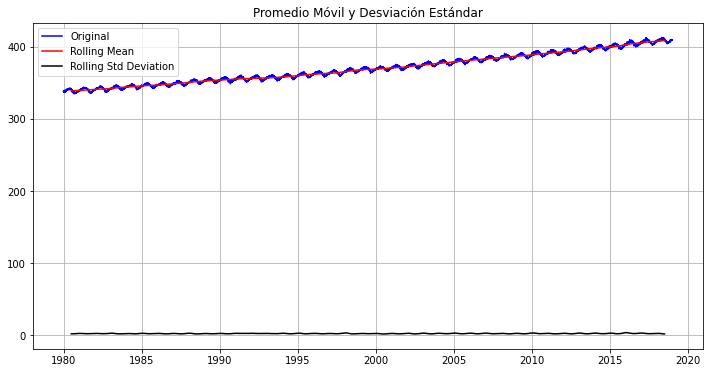

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                    -1.155189
p-value                            0.692569
#Lags Used                        42.000000
Number of Observations Used    14202.000000
Critical Value (1%)               -3.430811
Critical Value (5%)               -2.861744
Critical Value (10%)              -2.566878
dtype: float64


In [166]:
#
test_stationarity(ts_test)

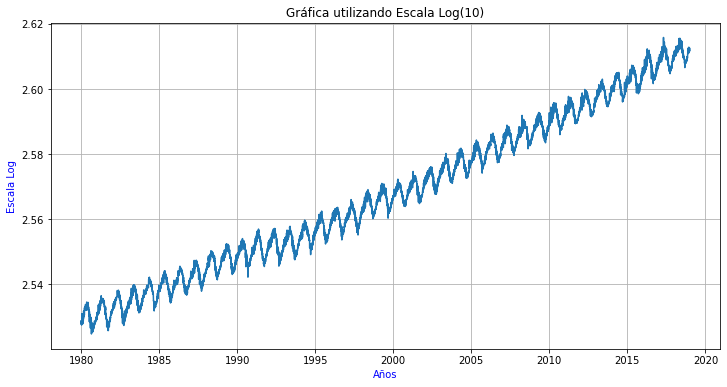

In [167]:
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();


In [168]:
#En la siguiente celda se comentan las graficas

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();


In [169]:
#Las datos observados se nota que cada vez son mas, y esto nos lo confirma la grafica de la tendencia que siempre es positiva, ya que los datos observados nunca han rompido un minimo del valle anterior, siempre aumentan
#respecto a la estacionalidad se nota que sigue siendo ciclica, hay periodos donde el CO2 se acumula mas y otras donde se rebaja, pero en general los ciclos del CO2 son demaciados rapidos, no hay tanta distancia entre sus diferentes valles, por lo que provoca que se acumule
#mucho mas rapido, respecto al residuo que es la resta de la tendencia y estacionalidad parece que esta dentro de un intervalo muy especifico, que es la constante entre ambas graficas

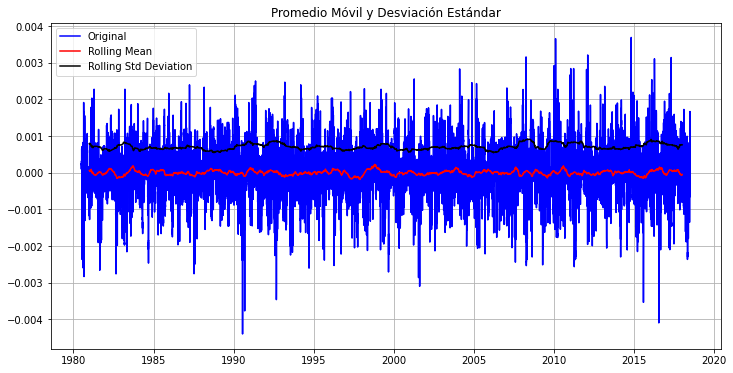

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.847383e+01
p-value                        2.137999e-30
#Lags Used                     2.200000e+01
Number of Observations Used    1.385800e+04
Critical Value (1%)           -3.430822e+00
Critical Value (5%)           -2.861749e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [170]:
ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

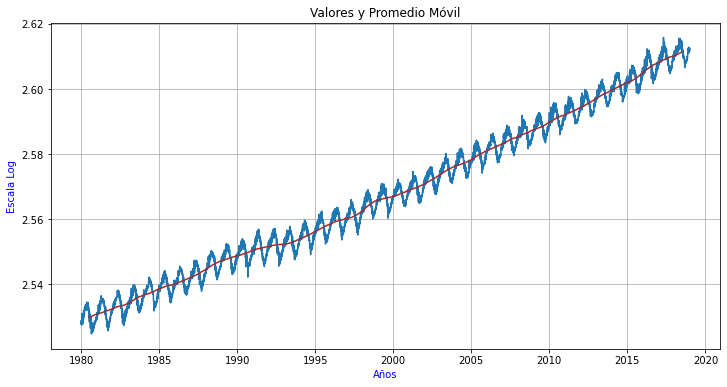

In [171]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [172]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
Name: value, dtype: float64

In [173]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1980-07-01    0.002344
1980-07-02    0.002353
1980-07-03    0.002196
1980-07-04    0.002207
1980-07-05    0.002192
Name: value, dtype: float64

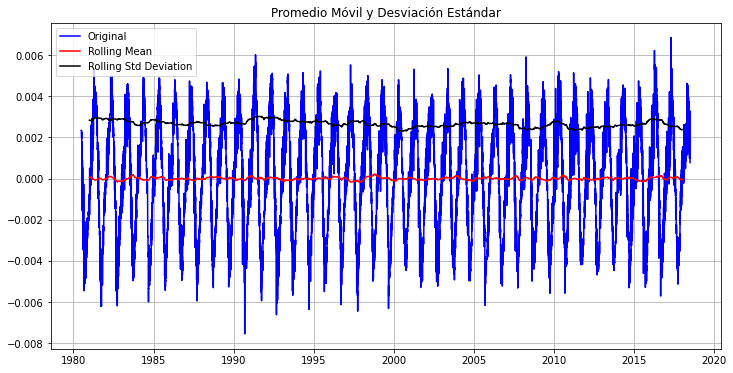

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.385363e+01
p-value                        6.931864e-26
#Lags Used                     4.200000e+01
Number of Observations Used    1.383800e+04
Critical Value (1%)           -3.430823e+00
Critical Value (5%)           -2.861749e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [174]:
test_stationarity(ts_test_log_moving_ave_diff)

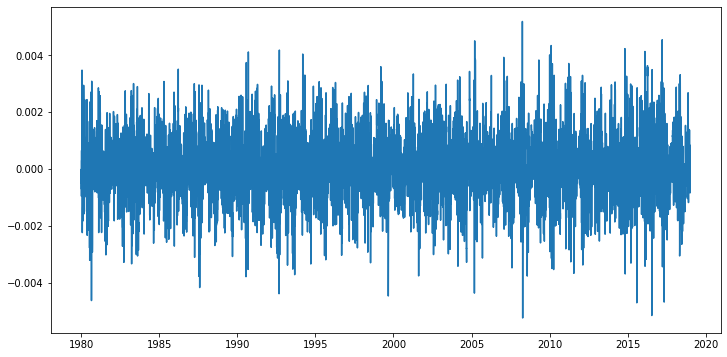

In [175]:
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);


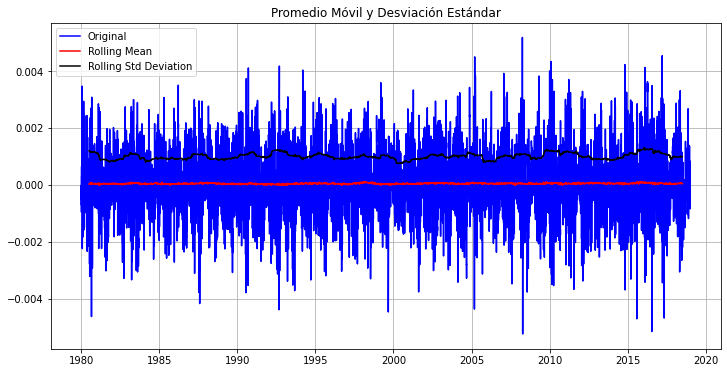

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.876005e+00
p-value                        3.881021e-17
#Lags Used                     4.200000e+01
Number of Observations Used    1.419500e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [176]:
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

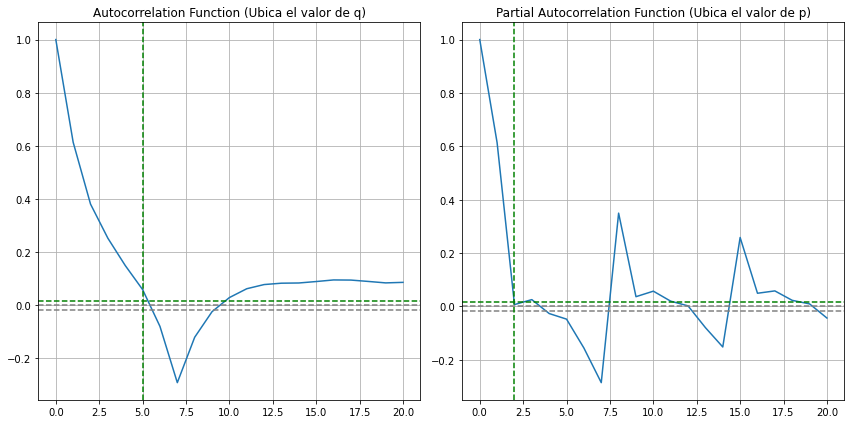

In [177]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=5, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14244
Model:                 ARIMA(2, 1, 0)   Log Likelihood               85371.167
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -170734.334
Time:                        06:06:53   BIC                        -170704.077
Sample:                    01-02-1980   HQIC                       -170724.270
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.874e-06   3.53e-06      1.665      0.096   -1.04e-06    1.28e-05
ar.L1.D.value    -0.2427      0.008    -29.505      0.000      -0.259      -0.227
ar.L2.D.value    -0.1909      0.008    -

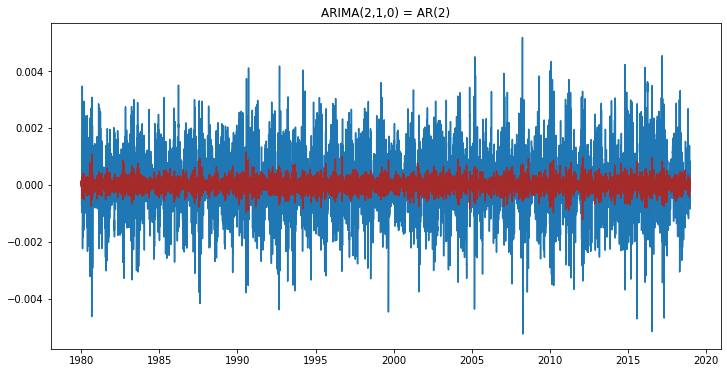

In [178]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14244
Model:                 ARIMA(0, 1, 5)   Log Likelihood               85673.704
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -171333.407
Time:                        06:06:57   BIC                        -171280.459
Sample:                    01-02-1980   HQIC                       -171315.795
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.877e-06   2.09e-06      2.812      0.005    1.78e-06    9.97e-06
ma.L1.D.value    -0.3000      0.008    -35.793      0.000      -0.316      -0.284
ma.L2.D.value    -0.1858      0.009    -

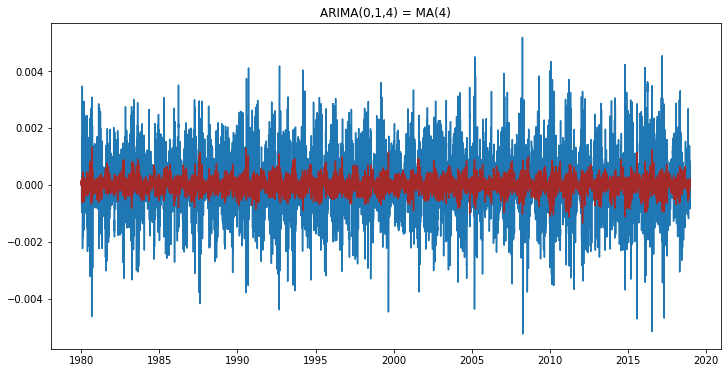

In [179]:
# Modelo MA(q): (p,d,q) = (0,1,5) 
model = ARIMA(ts_test_log, order=(0,1,5), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())



In [ ]:
# Modelo ARIMA(p): (p,d,q) = (2,1,5) 
model = ARIMA(ts_test_log, order=(2,1,5), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [ ]:
#Analizando las AIC
#1)-170734.334 
#2)-171333.407 -----> este es el mayor
#3)-171314.286

#por lo tanto lo volvemos a correr el segundo con (0,1,5)


In [ ]:
# Modelo MA(q): (p,d,q) = (2,1,5) 
model = ARIMA(ts_test_log, order=(0,1,5), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())



In [ ]:

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

In [ ]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())



In [ ]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');


In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)


In [ ]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test.tail(366*5)
predictions_ARIMA_last = predictions_ARIMA.tail(366*5)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');
